# Dimensionality Reduction via PCA

In this post we will play around with Dimensionality Reduction via Principal Component Analysis (PCA).
All the details about the math and the logic behind this topic are available in the blog post I published a couple of days ago, [Bridging Recommender Systems and Dimensionality Reduction](http://francescopochetti.com/bridging-recommender-systems-dimensionality-reduction/). As I have extensively treated the topic already, I will not get into the technical details again.
We are going to learn how PCA works applying it to three separate examples

1. Given a 2D toy dataset, we will reduce its dimensionality projecting the points onto a 1D straight line. This is purely didactic and will give us the intuition of what is happening under the hood. In 2D it is very easy to spot trends and to display the axes of maximum variance the algorithm spits out.
2. Once figured out the intuition, we will apply PCA to a real life dataset, a cropped version of the [labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/). The idea here is that we have $32 \times 32$ pixels greyscale pictures of faces and we want to reduce their size to $10 \times 10$, keeping as much information as possible about the original image. We still want to be able to recognize whose face we are looking at. It turns out that this is prefectly possible running PCA on the picture and projecting it on the subspace mapped by its top 100 (we can choose as many as we wish) principal components. This is an outstanding result as we will be able to shrink the size to less than half the original, still being able to "read" the face.
3. Last but not least we are going to follow up on the $K$-Means Clustering example I treated [here](http://francescopochetti.com/k-means-clustering/). The idea was to apply clustering to image compression. In a 24-bit color representation of an image, 1 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contained thousands of colors, still we managed to reduce their number to only to 16. We treated every pixel in the original image as a data example and used the K-means algorithm to find the 16 colors that best grouped (clustered) the pixels in the 3-dimensional RGB space. Once computed the cluster centroids on the image, we used the 16 colors to replace the pixels in the original image. Here we are going a step further, trying to visualize the clustering results in the 3D RGB space and then reducing the dimensionality to 2D via PCA.

### Functions

In [414]:
def featureNormalize(X):
    average = np.mean(X, axis=0)
    sigma = np.std(X, axis= 0)
    X = (X-average)/sigma
    return X, average, sigma

def pca(X):
    covariance = (1/X.shape[0])*X.T.dot(X)
    eigenval, eigenvec = np.linalg.eig(covariance)
    return eigenval, eigenvec

def projectData(X, eigenvectors, K):
    return X.dot(eigenvectors[:,0:K])

def reconstructData(Z, eigenvectors, K):
    return Z.reshape((-1, K)).dot(eigenvectors[:,0:K].T)

def displayData(X):
    m = int(np.sqrt(X.shape[1]))
    fig = plt.figure(figsize=(8,8))
    plt.title('100 Random faces from the data set')
    random.seed(0)
    indexes = random.sample(range(1, X.shape[0]), 100)
    images = X[indexes,:]
    for i in np.arange(10):
        for j in np.arange(10):
            ax = fig.add_subplot(10, 10, (10*j+i)+1)
            ax.matshow(ndimage.rotate(images[10*j+i,:].reshape(m,m),-90), cmap = 'gray')
            plt.yticks(())
            plt.xticks(())
            plt.axis('tight')

    plt.show()

def findClosestCentroids(X, centroids):
    """FINDCLOSESTCENTROIDS computes the centroid memberships for every example
       idx = FINDCLOSESTCENTROIDS (X, centroids) returns the closest centroids
       in idx for a dataset X where each row is a single example. idx = m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K]"""
    
    m = X.shape[0]
    idx = np.zeros((m, 1))

    for i in range(m):
        distances = np.linalg.norm(X[i,:] - centroids, axis=1)
        #distances = ((X[i,:] - centroids)**2).sum(axis=1)
        idx[i] = np.argmin(distances) + 1
    
    return idx.astype(int)

def computeCentroids(X, idx):
    """centroids = COMPUTECENTROIDS(X, idx, K) returns the new centroids by 
        computing the means of the data points assigned to each centroid. It is
        given a dataset X where each row is a single data point, a vector
        idx of centroid assignments (i.e. each entry in range [1..K]) for each
        example, and K, the number of centroids. You should return a matrix
        centroids, where each row of centroids is the mean of the data points
        assigned to it."""
    
    how_many = max(np.unique(idx))
    n = X.shape[1]
    centroids = np.zeros((how_many, n))
    
    for i in range(how_many):
        indices_of_centroid_i = X[np.where(idx == i+1)[0], :]
        centroids[i,:] = np.mean(indices_of_centroid_i, axis=0).reshape(1, n)
        
    return centroids

def kMeansInitCentroids(X, K):
    X = np.random.permutation(X)
    return X[:K,:]

def plotProgresskMeans(X, centroids_history, idx, iteration):
    latest_centroids = centroids_history[-3:]
    how_many = max(np.unique(idx))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=idx, cmap=plt.cm.bwr)

    for i in range(how_many):
        centroid_i = centroids_history[i+1::3]
        plt.plot(centroid_i[:, 0], centroid_i[:, 1], ':bo', c='k', alpha=0.5)
    
    plt.plot(latest_centroids[:, 0], latest_centroids[:, 1], 'o', c='k')

    plt.axis('tight')
    title = 'Iteration Number: ' + str(iteration + 1)
    plt.title(title)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
    plt.tick_params(axis='y', which='both', right='off', left='off', labelleft='off') 
    plt.show()

def runkMeans(X, initial_centroids, max_iters, plot_progress=False):
    """[centroids, idx] = RUNKMEANS(X, initial_centroids, max_iters, ...
       plot_progress) runs the K-Means algorithm on data matrix X, where each 
       row of X is a single example. It uses initial_centroids used as the
       initial centroids. max_iters specifies the total number of interactions 
       of K-Means to execute. plot_progress is a true/false flag that 
       indicates if the function should also plot its progress as the 
       learning happens. This is set to false by default. runkMeans returns 
       centroids, a Kxn matrix of the computed centroids and idx, a m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K])"""
    
    # initializing variables
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    centroids_history = initial_centroids
    idx = np.zeros((m, 1))
    
    for i in range(max_iters):
        # For each example in X, assign it to the closest centroid
        idx = findClosestCentroids(X, centroids)
        
        # Optionally, plot progress here
        if plot_progress:
            plotProgresskMeans(X, centroids_history, idx, i)
    
        # Given the memberships, compute new centroids
        centroids = computeCentroids(X, idx)
        centroids_history = np.vstack((centroids_history, centroids))
    
    # Given the final centroids, assign each input to the closest centroid
    idx = findClosestCentroids(X, centroids)
    
    return centroids, idx

## Part 1: From 2D to straight line. Visualizing the Principal Components

2D dataset. It seems like the 2 variables are strongly correlated.
We could think about condensing all the relevant information on one single line..

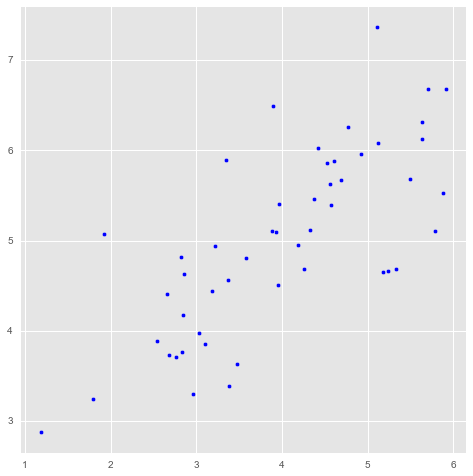

In [434]:
import scipy.io
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from scipy import ndimage
from skimage import io

mat = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex7-005\\mlclass-ex7\ex7data1.mat')
X = mat['X']

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1])

plt.axis('tight')
plt.show()

Here the results of PCA. The continuous and dashed segments indicate the directions of the 2 Principal Components.
Nothing else than the 2 orthonormal eigenvectors of the covariance of X.

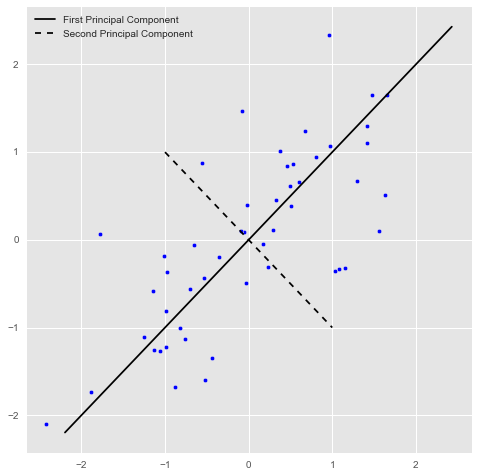

In [435]:
X, average, sigma = featureNormalize(X)

princip_varian, princip_comp = pca(X)

first_x = np.array([min(X[:,1])-0.1, max(X[:,1])+0.1])
first_y = princip_comp[:,0][1]/princip_comp[:,0][0] * plotx1

second_x = np.array([-1, 1])
second_y = princip_comp[:,1][1]/princip_comp[:,1][0] * plotx2

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.plot(first_x, first_y, color='k', label='First Principal Component')
plt.plot(second_x, second_y, color='k', linestyle='--', label='Second Principal Component')
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

As you may have noticed the most variance is concentrated around the first principal component.
Here what happens when we project X onto it. Two dimensions are summarized in one.

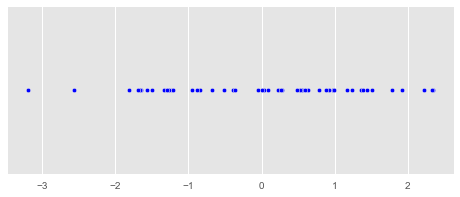

In [436]:
Z = projectData(X, princip_comp, 1)

plt.figure(figsize=(8, 3))
plt.scatter(Z, len(Z) * [1])
plt.yticks(())
plt.axis('tight')
plt.show()

Here instead we reconstruct the original dataset from its reduced version. The blue dots isthe result.
As Z had only one dimension, if we try bulding X back we lose the information contained on the second principal component.
Hence we find ourselves with blue dots prefectly aligned. The red dots belong to the original dataset.
Therefore the dashed black segments represent the reconstruction error.

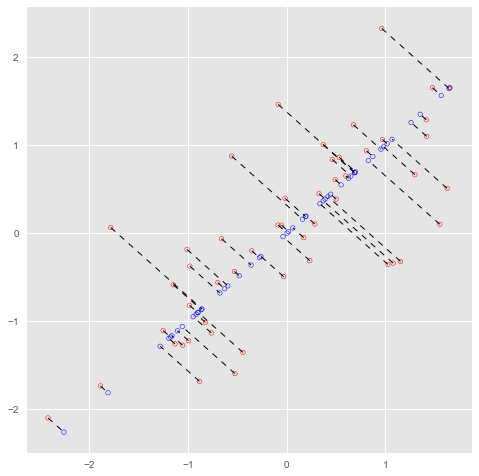

In [437]:
X_rec = reconstructData(Z, princip_comp, 1)

plt.figure(figsize=(8, 8))
plt.scatter(X_rec[:, 0], X_rec[:, 1], facecolors='none', edgecolors='b')
plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='r')

for i in range(X.shape[0]):
    plt.plot([X[i,0], X_rec[i,0]], [X[i,1], X_rec[i,1]], color='k', linestyle='--', lw=1)
    
plt.axis('tight')
plt.show()

## Part 2: PCA on the Face dataset 

As you can see, the first set of images reproduce faces without any specific approximation. The second set, instead, show what happens when we shrink the size of the single pictures from $32 \times 32$ to $10 \times 10$ using PCA. Thre interesting aspect here is that even though we have more than halved the dimension, the faces are still pretty recognizable! This is because we have kept the most important information using PCA. 

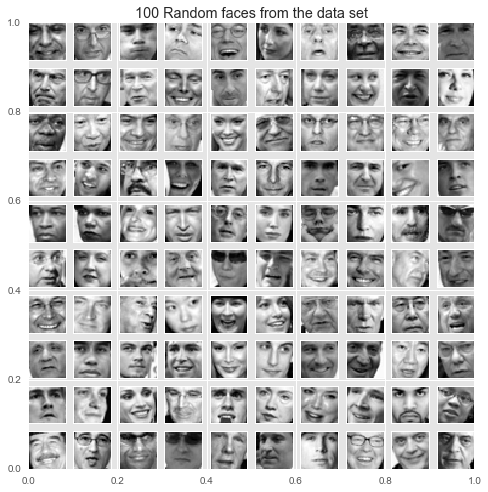

In [419]:
mat = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex7-005\\mlclass-ex7\ex7faces.mat')
X = mat['X']

displayData(X)

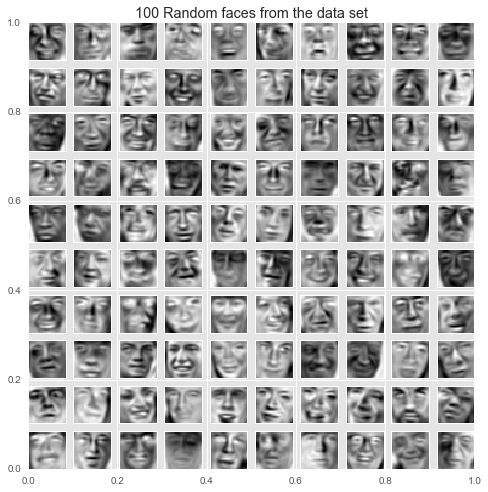

In [420]:
X, average, sigma = featureNormalize(X)

princip_varian, princip_comp = pca(X)

Z = projectData(X, princip_comp, 100)

X_rec = reconstructData(Z, princip_comp, 100)
displayData(X_rec)

## Part 3: Visualizing K-Means Clusters via PCA 

As you can see the compressed image has a much lower resolution than the original one.
This is due to the fact that we are just using 16 colors to represent our exotic bird!


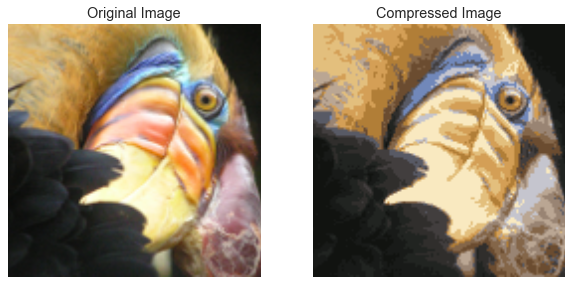

In [421]:
bird_original = io.imread('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex7-005\\mlclass-ex7\\bird_small.png')

# Divide by 255 so that all values are in the range 0 - 1
bird = bird_original/255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on
bird = bird.reshape((bird.shape[0]*bird.shape[1], bird.shape[2]))

K = 16
max_iters = 10

# When using K-Means, it is important the initialize the centroids randomly
initial_centroids = kMeansInitCentroids(bird, K)

# running K-means
centroids, idx = runkMeans(bird, initial_centroids, max_iters)

bird_compressed = np.zeros((bird.shape[0], bird.shape[1]))

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by it's index in idx) to the centroid value
for i, cluster in enumerate(idx):
    bird_compressed[i,:] = centroids[int(cluster[0]) - 1,:]

# Reshape the recovered image into proper dimensions
bird_compressed = bird_compressed.reshape((bird_original.shape[0], bird_original.shape[1], bird_original.shape[2]))

print('As you can see the compressed image has a much lower resolution than the original one.')
print('This is due to the fact that we are just using 16 colors to represent our exotic bird!')

fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
ax1.imshow(bird_original)
ax1.set_title('Original Image')
plt.xticks(())
plt.yticks(())

ax2 = fig.add_subplot(122)
ax2.imshow(bird_compressed)
ax2.set_title('Compressed Image')
plt.xticks(())
plt.yticks(())

plt.show()

Now that we have succesfully shrinked our bird, let's explore the results of the K-Means algorithm. How are pixels grouped together? We can visualize the data points in 3D and then projecting them on the best possible 2D axes provided by PCA 

In [422]:
bird_pca = np.hstack((bird, idx))

3D visualization

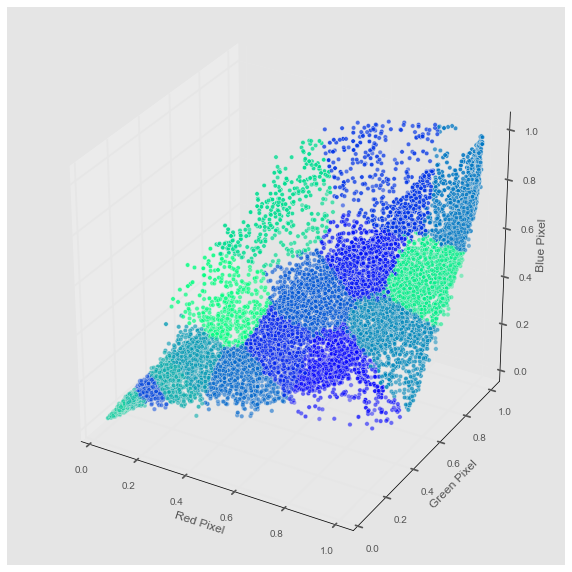

In [423]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(bird_pca[:,0], bird_pca[:,1], bird_pca[:,2], c=bird_pca[:,3], cmap='winter')

ax.set_xlabel('Red Pixel')
ax.set_ylabel('Green Pixel')
ax.set_zlabel('Blue Pixel')
plt.axis('tight')
plt.show()

Shrinking to 2D via Principal Component Analysis

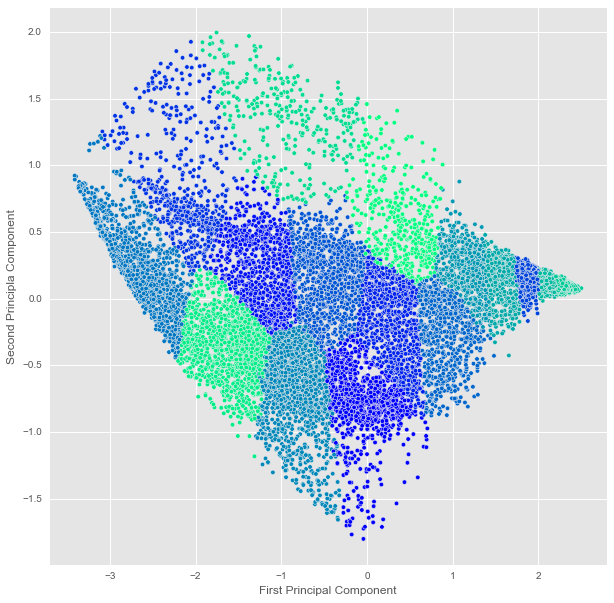

In [427]:
bird, average, sigma = featureNormalize(bird)

princip_varian, princip_comp = pca(bird)
bird_Z = projectData(bird, princip_comp, 2)
bird_pca = np.hstack((bird_Z, idx))
plt.figure(figsize=(10, 10))
plt.scatter(bird_pca[:, 0], bird_pca[:, 1], c=bird_pca[:, 2], zorder=10, cmap='winter')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principla Component')

plt.axis('tight')
plt.show()